# SVM CLASSIFICATION - Yangswei_85 dataset - TF-IDF

In this notebook, we experiment with SVM models to classify emotion labels. By employing these techniques, we aim to analyze the effectiveness of each model in capturing the nuances of emtions expression in texts. This implementation is based on the yangswei_85 dataset and utilizes the TF-IDF transformation.

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import spacy
import time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2  
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform  
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Import data

In [6]:
# Import training set
data = pd.read_csv('train_yangswei_85.csv')

In [7]:
data.head()

,text,label
0,How can i miss work if i work from home questi...,joy
1,How do you deal with being the only person in ...,sadness
2,I began my application to remote jobs yesterda...,joy
3,Anyone else question mine sit in the window si...,joy
4,What household chore did you get done today wh...,anger


In [8]:
# Count the occurences in each class of training set
label_counts = data['label'].value_counts()
label_counts

label
joy         53409
sadness     16033
anger       13183
fear         4621
surprise     1250
love          656
Name: count, dtype: int64

In [9]:
# Import test set
test_data = pd.read_csv('test_yangswei_85.csv')

## Preprocessing

In [10]:
# Download necessary NLTK resources
download('punkt')  # For tokenization
download('stopwords')  # For stopwords

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to C:\Users\minhd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minhd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def preprocess_text(text):
    # lowercase 
    text = text.lower()

    tokens = word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # lemmatization (using SpaCy)
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]

    # return to string 
    return " ".join(lemmatized_tokens)

In [12]:
# Preprocessing with training data
data['processed_text'] = data['text'].apply(preprocess_text)

In [13]:
# Preprocessing with test data 
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# SVM

In [16]:
# Assigning the text from the training set
X_train = data['processed_text']
y_train = data['label']
# Assigning the text from the test set 
X_test = test_data['processed_text']
y_test = test_data['label']

## Text Tokenization Using CountVectorizer

In this section, we used the CountVectorizer to transform the texts into a matrix of token counts, where each word’s occurrence is counted. By this way, we have the frequency of words, which is essential for analyzing and modeling text data. This approach helps in identifying important features in the text, enabling the model to recognize patterns and relationships within the data.

In [17]:
start_time = time.time()
# Convert a collection of text documents to a matrix of token counts.
vect = CountVectorizer(min_df=5)  

# Learn the vocabulary from the training data
print('fit')
vect.fit(X_train)

# Transform the training set
print('transform')
X_train_tok = vect.transform(X_train)

end_time = time.time()
print('done')

# Transform the test set
X_test_tok = vect.transform(X_test)

fit
transform
done


In [18]:
# Calculate the time taken for the transformation process
elapsed_time = end_time - start_time
print(f"Time employed: {elapsed_time:.2f} seconds")
len(vect.vocabulary_)

Time employed: 9.65 seconds


9344

In [19]:
# Access the vocabulary (unique words) learned by the CountVectorizer
vect.vocabulary_

{'miss': 5210,
 'work': 9207,
 'home': 3837,
 'question': 6544,
 'way': 9035,
 'would': 9245,
 'office': 5645,
 'sick': 7435,
 'consider': 1675,
 'go': 3481,
 'sitting': 7488,
 'desk': 2174,
 'day': 2016,
 'due': 2520,
 'exhaustion': 2879,
 'say': 7153,
 'feel': 3026,
 'well': 9071,
 'need': 5424,
 'elaborate': 2617,
 'reason': 6658,
 'deal': 2034,
 'person': 6028,
 'social': 7606,
 'circle': 1364,
 'wfh': 9089,
 'family': 2972,
 'extra': 2929,
 'time': 8341,
 'give': 3456,
 'could': 1796,
 'see': 7250,
 'result': 6923,
 'isolation': 4384,
 'begin': 750,
 'application': 404,
 'remote': 6801,
 'job': 4444,
 'yesterday': 9305,
 'consistently': 1682,
 'apply': 406,
 'comment': 1529,
 'back': 621,
 'hire': 3808,
 'long': 4829,
 'take': 8118,
 'pm': 6170,
 'taxis': 8153,
 'winwin': 9167,
 'anyone': 371,
 'else': 2645,
 'mine': 5177,
 'sit': 7482,
 'window': 9159,
 'lap': 4601,
 'chair': 1260,
 'towards': 8417,
 'front': 3290,
 'half': 3635,
 'try': 8525,
 'walk': 8987,
 'across': 86,
 'keyb

# Implement SVM without Class Weights¶

Without Class Weights: we train the SVM model without using any specific weights to the classes. This approach relies mainly on the inherent distribution of the dataset

## LinearSVM

In the pipeline below, we selected the top k features that are most relevant to the target variable using the chi-squared (chi2) statistical test. Then, the raw term frequency matrix was transformed into a TF-IDF representation. Next, we chose the LinearSVC as the learning algorithm and added in the pipeline. In hyperparameters tuning, we used Randomized Search to select the optimal parameters. Finally, we implemented the classification by the model with these parameters.

In [20]:
# Create the pipeline with Linear SVM
opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

In [21]:
# Implement Hyperparameters tunning
budget = 10

r_param_grid = [
    {'sel__k': [200, 1000, 2000, 3000, 4000, 'all'], 'learner__C': loguniform(0.01, 100)},  
]

optr_search = RandomizedSearchCV(opt_pipeline, r_param_grid, cv=5, n_iter=budget, n_jobs=3, verbose=True).fit(X_train_tok, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [23]:
# Retrieve the best model from the search results
optr_search.best_params_
best_model_linear = optr_search.best_estimator_

In [70]:
# Show the best parameters
best_model_linear

Pipeline(steps=[('sel',
                 SelectKBest(k=4000,
                             score_func=<function chi2 at 0x00000167BD3A7600>)),
                ('tfidf', TfidfTransformer()),
                ('learner', LinearSVC(C=3.129812195211403))])

In [27]:
# Show Classification Report
optr_predictions = best_model_linear.predict(X_test_tok)

from sklearn.metrics import classification_report, accuracy_score

print(f"Accuracy: {accuracy_score(y_test, optr_predictions)}")

print("Classification Report:")
print(classification_report(y_test, optr_predictions))

Accuracy: 0.7765714029341828
Classification Report:
              precision    recall  f1-score   support

       anger       0.71      0.51      0.60      3296
        fear       0.67      0.39      0.49      1155
         joy       0.80      0.93      0.86     13353
        love       0.72      0.40      0.51       164
     sadness       0.75      0.63      0.68      4008
    surprise       0.75      0.68      0.71       313

    accuracy                           0.78     22289
   macro avg       0.73      0.59      0.64     22289
weighted avg       0.77      0.78      0.76     22289



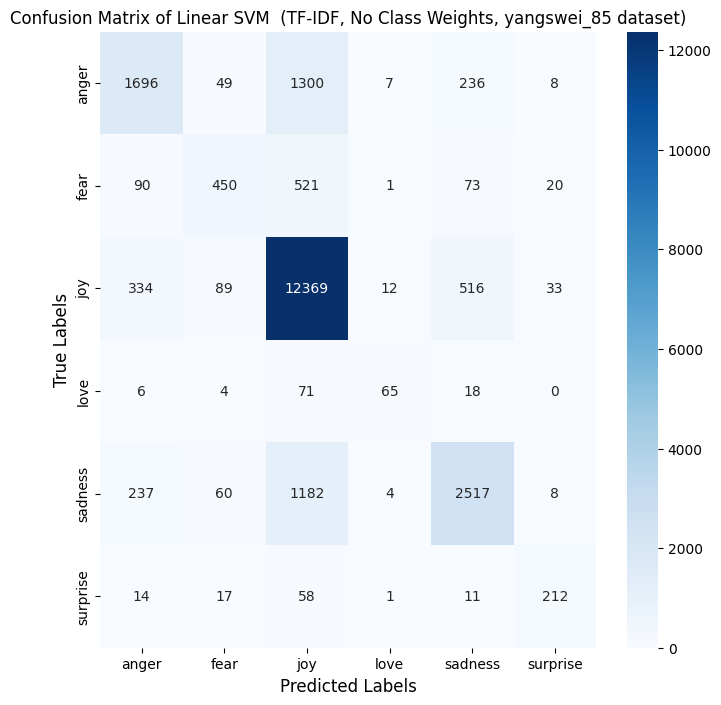

In [74]:
# Show Confusion Matrix figure 
conf_matrix_linear = confusion_matrix(y_test, optr_predictions)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_linear, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], 
            yticklabels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix of Linear SVM  (TF-IDF, No Class Weights, yangswei_85 dataset)', fontsize=12)
plt.show()

## Non linear SVM, kernel RBF

The pipeline is almost the same as the one above, but we use a non-linear SVM with an 'RBF' kernel. We selected the top k features most relevant to the target variable using the chi-squared (chi2) statistical test. Then, the raw term frequency matrix was transformed into a TF-IDF representation. Finally, we selected the SVC(kernel RBF) as a learning algorithm and added it to the pipeline. Random search was used to find the optimal parameters in this part as well. Finally, we ran the model with those optimal parameter

In [29]:
# Create the pipeline with SVM and RBF kernel
opt_pipeline_rbf = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', SVC(kernel='rbf'))  # Non-linear SVM with RBF kernel
])

# Define the parameter grid for RandomizedSearchCV
r_param_grid_rbf = [
    {'sel__k': [2000, 3000], 
     'learner__C': loguniform(0.01, 100),  # C parameter of the SVM
     'learner__gamma': ['scale', 'auto']}  # Gamma parameter of the RBF kernel
]

In [30]:
# Implement hyperparameters tunning
optr_search_rbf = RandomizedSearchCV(opt_pipeline_rbf, r_param_grid_rbf, cv=2, n_iter=2, n_jobs=-1, verbose=True)
optr_search_rbf.fit(X_train_tok, y_train)
best_model_rbf = optr_search_rbf.best_estimator_

Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [56]:
# Show the optimal parameters
optr_search_rbf.best_params_

{'learner__C': 0.02765681515572926, 'learner__gamma': 'auto', 'sel__k': 2000}

In [57]:
# Show Classification Report
y_pred_rbf = best_model_rbf.predict(X_test_tok)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf)}")

print("Classification Report:")
print(classification_report(y_test, y_pred_rbf))

Accuracy: 0.5990847503252725
Classification Report:


C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3296
        fear       0.00      0.00      0.00      1155
         joy       0.60      1.00      0.75     13353
        love       0.00      0.00      0.00       164
     sadness       0.00      0.00      0.00      4008
    surprise       0.00      0.00      0.00       313

    accuracy                           0.60     22289
   macro avg       0.10      0.17      0.12     22289
weighted avg       0.36      0.60      0.45     22289



C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Implement SVM with Class Weights

Class Weights: we used them to address class imbalance in the training data. By computing and applying these weights during model training, we aim to improve the classifier's performance on minority classes.

In [40]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(class_weight_dict)

{'anger': 1.1271081443272901, 'fear': 3.2154656279304623, 'joy': 0.27820529623596524, 'love': 22.650406504065042, 'sadness': 0.9267552339965488, 'surprise': 11.886933333333333}


### LinearSVM, using Class Weights

In [42]:
# Create the pipeline with Linear SVM
opt_pipeline_class_weight = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC(class_weight=class_weight_dict))  # learning algorithm
])

In [43]:
# Implement Hyperparameters tunning
budget = 10

r_param_grid = [
    {'sel__k': [200, 1000, 2000, 3000, 4000, 'all'], 'learner__C': loguniform(0.01, 100)},  
]

optr_search_class_weight = RandomizedSearchCV(opt_pipeline_class_weight, r_param_grid, cv=5, n_iter=budget, n_jobs=3, verbose=True).fit(X_train_tok, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [44]:
# Get and retrieve the best model from the search results
optr_search_class_wight.best_params_
best_model_linear_class_weight = optr_search_class_weight.best_estimator_

In [73]:
# Show the optimal parameters
best_model_linear_class_weight

Pipeline(steps=[('sel',
                 SelectKBest(k=4000,
                             score_func=<function chi2 at 0x00000167BD3A7600>)),
                ('tfidf', TfidfTransformer()),
                ('learner',
                 LinearSVC(C=2.170308261777149,
                           class_weight={'anger': 1.1271081443272901,
                                         'fear': 3.2154656279304623,
                                         'joy': 0.27820529623596524,
                                         'love': 22.650406504065042,
                                         'sadness': 0.9267552339965488,
                                         'surprise': 11.886933333333333}))])

In [45]:
# Show Classification Report
pred_linear_class_weight = best_model_linear_class_weight.predict(X_test_tok)
print(f"Accuracy: {accuracy_score(y_test, pred_linear_class_weight)}")

print("Classification Report:")
print(classification_report(y_test, pred_linear_class_weight))

Accuracy: 0.7601956121853829
Classification Report:
              precision    recall  f1-score   support

       anger       0.63      0.62      0.63      3296
        fear       0.45      0.65      0.53      1155
         joy       0.86      0.83      0.85     13353
        love       0.28      0.42      0.33       164
     sadness       0.71      0.69      0.70      4008
    surprise       0.65      0.70      0.67       313

    accuracy                           0.76     22289
   macro avg       0.60      0.65      0.62     22289
weighted avg       0.77      0.76      0.76     22289



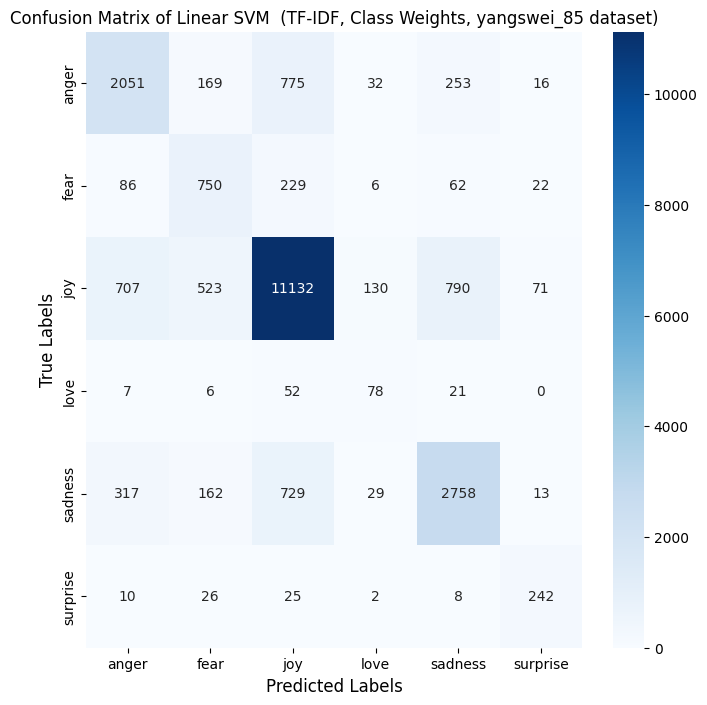

In [75]:
# Show Confusion Matrix figure of Linear SVM with Class Weights model
conf_matrix_linear = confusion_matrix(y_test, pred_linear_class_weight)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_linear, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], 
            yticklabels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix of Linear SVM  (TF-IDF, Class Weights, yangswei_85 dataset)', fontsize=12)
plt.show()

### Non Linear SVM, kernel RBF, using Class Weights

In [51]:
# Create the pipeline with SVM and RBF kernel
opt_pipeline_rbf_class_weight = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', SVC(kernel='rbf', class_weight=class_weight_dict))  # Non-linear SVM with RBF kernel
])

# Define the parameter grid for RandomizedSearchCV
r_param_grid_rbf_class_weight = [
    {'sel__k': [2000, 3000], 
     'learner__C': loguniform(0.01, 100),  # C parameter of the SVM
     'learner__gamma': ['scale', 'auto']}  # Gamma parameter of the RBF kernel
]

In [52]:
# Implement hyperparameters tunning
optr_search_rbf_class_weight = RandomizedSearchCV(opt_pipeline_rbf_class_weight, r_param_grid_rbf_class_weight, cv=2, n_iter=2, n_jobs=-1, verbose=True)
optr_search_rbf_class_weight.fit(X_train_tok, y_train)
best_model_rbf_class_weight = optr_search_rbf_class_weight.best_estimator_

Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [54]:
# Show the optimal parameters
optr_search_rbf_class_weight.best_params_

{'learner__C': 12.619341873532408, 'learner__gamma': 'auto', 'sel__k': 2000}

In [55]:
# Show Classification Report
pred_rbf_class_weight = best_model_rbf_class_weight.predict(X_test_tok)
print(f"Accuracy: {accuracy_score(y_test, pred_rbf_class_weight)}")

print("Classification Report:")
print(classification_report(y_test, pred_rbf_class_weight))

Accuracy: 0.5367670151195657
Classification Report:
              precision    recall  f1-score   support

       anger       0.39      0.54      0.45      3296
        fear       0.20      0.51      0.29      1155
         joy       0.81      0.54      0.64     13353
        love       0.10      0.65      0.17       164
     sadness       0.47      0.53      0.50      4008
    surprise       0.55      0.79      0.65       313

    accuracy                           0.54     22289
   macro avg       0.42      0.59      0.45     22289
weighted avg       0.65      0.54      0.57     22289



## Save metrics

In this section, we implemented code to save the best models we trained. We decided to select two models: the first is a Linear SVM without class weights, and the second is a Linear SVM with class weights. Both demonstrated better performance compared to the other models.

In [62]:
def save_metrics_to_file(y_test, optr_predictions, file_name):
    # Accuracy
    accuracy = accuracy_score(y_test, optr_predictions)

    # Classification report
    class_report = classification_report(y_test, optr_predictions, output_dict=True)
    
    # Confusion matrix
    conf_matrix_linear = confusion_matrix(y_test, optr_predictions)

    # Extract metrics from the classification report
    macro_precision = class_report['macro avg']['precision']
    macro_recall = class_report['macro avg']['recall']
    macro_f1 = class_report['macro avg']['f1-score']
    
    weighted_precision = class_report['weighted avg']['precision']
    weighted_recall = class_report['weighted avg']['recall']
    weighted_f1 = class_report['weighted avg']['f1-score']
    
    # Replace invalid characters in the file name
    safe_file_name = file_name.replace(" ", "_").replace("(", "").replace(")", "").replace(",", "").replace("&", "and")
    # Save the results
    results_dir = 'results/results_SVM_classification/'
    
    # Create the full path for the results file
    metrics_filepath = os.path.join(results_dir, f'metrics_{safe_file_name}.txt')

    # Write the results to the file
    with open(metrics_filepath, 'w') as file:
        # Accuracy
        file.write(f"Test Accuracy: {accuracy:.4f}\n")
        file.write("\n")
        
        # Macro metrics
        file.write("Macro metrics\n")
        file.write(f"Macro precision: {macro_precision:.4f}\n")
        file.write(f"Macro recall: {macro_recall:.4f}\n")
        file.write(f"Macro F1 score: {macro_f1:.4f}\n")
        file.write("\n")
        
        # Weighted metrics
        file.write("Weighted metrics\n")
        file.write(f"Weighted precision: {weighted_precision:.4f}\n")
        file.write(f"Weighted recall: {weighted_recall:.4f}\n")
        file.write(f"Weighted F1 score: {weighted_f1:.4f}\n")
        file.write("\n")
        
        # Classification report
        file.write("Classification report:\n")
        file.write(classification_report(y_test, optr_predictions))
        file.write("\n")
        
        # Confusion matrix
        file.write("Confusion matrix:\n")
        file.write(np.array_str(conf_matrix_linear))
        file.write("\n")

In [63]:
SVM_linear_tdif_noweight_yangswei_85 = "Linear SVM  (TF-IDF Embedding, No Class Weights, yangswei85 dataset)"
save_metrics_to_file(y_test, optr_predictions, SVM_linear_tdif_noweight_yangswei_85)

In [64]:
SVM_linear_tdif_weight_yangswei_85 = "Linear SVM  (TF-IDF Embedding, Class Weights, yangswei_85 dataset)"
save_metrics_to_file(y_test, pred_linear_class_weight, SVM_linear_tdif_weight_yangswei_85)